# Lower Dimensional Training

In [1]:
import torch
import torch.nn as nn

import numpy as np
import torchvision
from torchvision import datasets, transforms

from pathlib import Path

import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy import signal

from tqdm import tqdm

import FrEIA.framework as fw
import FrEIA.modules as mods

DIM = 32
device = 'cuda' if torch.cuda.is_available() else 'cpu'

def make_cond(labels):
    cond_tensor = torch.zeros(labels.size(0), 10).cuda()

    cond_tensor.scatter_(1, labels.view(-1, 1), 1.)

    return cond_tensor

def tensor2imgs(t, nrow=10):
    imgrid = torchvision.utils.make_grid(t, nrow, pad_value=1)
    return imgrid.data.mul(255).clamp(0, 255).byte().cpu().numpy()

def init_inn(mod):
    for key, param in mod.named_parameters():
        split = key.split('.')
        if param.requires_grad:
            param.data = 0.03 * torch.randn(param.data.shape).cuda()
            if split[3][-1] == '3': # last convolution in the coeff func
                param.data.fill_(0.)

In [ ]:
train_loader = torch.utils.data.DataLoader(
    datasets.FakeData(size=240000, image_size=(1, DIM, DIM),
                      transform=transforms.Compose([
                          transforms.ToTensor(),
                      ])),
    batch_size=512, shuffle=True, pin_memory=True, num_workers=4,
    drop_last=True
)

In [2]:
def INN(coupling_type, nch, dim, n_blocks, internal_width, clamping):
    layer_types = {
        'NICE': mods.NICECouplingBlock,
        'RNVP': mods.RNVPCouplingBlock,
        'GLOW': mods.GLOWCouplingBlock,
        'GIN': mods.GINCouplingBlock,
    }

    cond_size = 10
    cond_node = fw.ConditionNode(cond_size)

    def subnet_constructor(ch_in, ch_out):
        return mods.F_fully_connected(ch_in, ch_out, internal_size=internal_width)

    mod_args = {
                'subnet_constructor': subnet_constructor,
    }

    if coupling_type is not 'NICE':
        mod_args['clamp'] = clamping

    nodes = [fw.InputNode(nch, dim, dim, name='inp')]

    nodes.append(fw.Node([nodes[-1].out0], mods.flattening_layer, {}, name='flatten'))

    for i in range(n_blocks):
        nodes.append(fw.Node([nodes[-1].out0], mods.permute_layer, {'seed': i},
                             name=F'permute_{i}'))

        nodes.append(fw.Node(
            [nodes[-1].out0], layer_types[coupling_type], mod_args, conditions=cond_node, name=F'fc_{i}'
        ))

    nodes.append(fw.OutputNode([nodes[-1].out0], name='out'))
    nodes.append(cond_node)

    return fw.ReversibleGraphNet(nodes, verbose=False)

model = INN('GLOW', 1, 32, 1, 512, 1.5).to(device)
init_inn(model)

In [3]:
def train(n_epochs):
    print(f'{"epoch":>15}{"nll":>15}')
    optimizer = torch.optim.Adam(model.parameters(),
                                     lr=1e-4,
                                     betas=[0.9, 0.999], weight_decay=1e-5)
#     scheduler = torch.optim.lr_scheduler.StepLR(
#         optimizer, c.lr_step, c.lr_step
#     )
    dist = torch.distributions.normal.Normal(torch.zeros(1, device=device), torch.ones(1, device=device))
    for epoch in range(n_epochs):
        
        losses = []

        for n in tqdm(range(240000//512)):
            n_iter = n + (epoch * 240000//512)

#             samples = torch.randn(512, 2, 2, device=device)
            samples = dist.sample((512, 1, 32, 32))
            targets = torch.randint(0, 10, (512,), dtype=torch.long, device=device)
#             samples = samples.to(device, non_blocking=True)
#             targets = targets.to(device, non_blocking=True)

            cond = make_cond(targets)

            optimizer.zero_grad()

            output = model(samples, cond)
            zz = torch.sum(output**2, dim=1)
            jac = model.jacobian(run_forward=False)

            neg_log_likeli = 0.5 * zz - jac

            nll_loss = torch.mean(neg_log_likeli)
            nll_loss.backward()
            
            losses.append(nll_loss.item())

            optimizer.step()
            
        print(f'{str(epoch):>15}{f"{np.array(losses).mean():.5f}":>15}')
        
train(10)

  0%|          | 0/468 [00:00<?, ?it/s]

          epoch            nll


/home/tillb/Projects/extreme-gan/mnist/FrEIA/framework.py:438: UserWarning: This function computes the log-jacobian determinant, not the jacobian as the name suggest. Will be removed in the future.
  warnings.warn("This function computes the log-jacobian determinant, not the "
  4%|▎         | 17/468 [00:00<00:02, 166.49it/s]

              0      511.95363


  3%|▎         | 14/468 [00:00<00:03, 139.09it/s]

              1      511.95989


  3%|▎         | 16/468 [00:00<00:02, 155.73it/s]

              2      511.94737


  3%|▎         | 16/468 [00:00<00:02, 153.08it/s]

              3      511.97778


  4%|▎         | 17/468 [00:00<00:02, 161.09it/s]

              4      511.92516


  3%|▎         | 15/468 [00:00<00:03, 149.57it/s]

              5      512.04911


  3%|▎         | 15/468 [00:00<00:03, 141.78it/s]

              6      511.98097


  3%|▎         | 16/468 [00:00<00:02, 153.64it/s]

              7      511.99630


  3%|▎         | 15/468 [00:00<00:03, 141.49it/s]

              8      511.95681


100%|██████████| 468/468 [00:03<00:00, 155.86it/s]

              9      511.98900


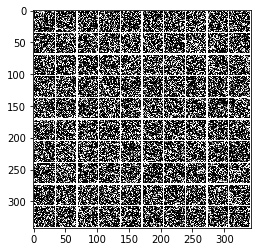

In [4]:
with torch.no_grad():
    noise = torch.randn(100, 32 * 32, device=device)
    samples = model(noise, make_cond(torch.zeros(100, device=device, dtype=torch.long)), rev=True)
    plt.imshow(tensor2imgs(samples.reshape(-1, 1, 32, 32)).transpose(1, 2, 0))
    plt.show()

In [5]:
out_pos = torch.empty(0, 32 * 32)
in_pos = torch.empty(0,32 * 32)
classes = torch.empty(0).long()
with torch.no_grad():
    dist = torch.distributions.normal.Normal(torch.zeros(1, device=device), torch.ones(1, device=device))
    for n in tqdm(range(240000//512)):
        x = dist.sample((512, 1, 32, 32))
        y = torch.randint(0, 10, (512,), dtype=torch.long, device=device)
        in_pos = torch.cat([in_pos, x.reshape(-1, 32*32).data.cpu()])
        output = model(x, make_cond(y))
        out_pos = torch.cat([out_pos, output.data.cpu()])
        classes = torch.cat([classes, y.data.cpu()])

100%|██████████| 468/468 [03:04<00:00,  2.54it/s]


In [6]:
with torch.no_grad():
    mean = out_pos.mean(dim=0).to(device)
    cov = torch.tensor(np.cov(out_pos.cpu().numpy().T), device=device, dtype=torch.float)
    icov = torch.inverse(cov)
    w, v = torch.eig(cov, eigenvectors=True)

100%|██████████| 4/4 [00:00<00:00,  9.33it/s]


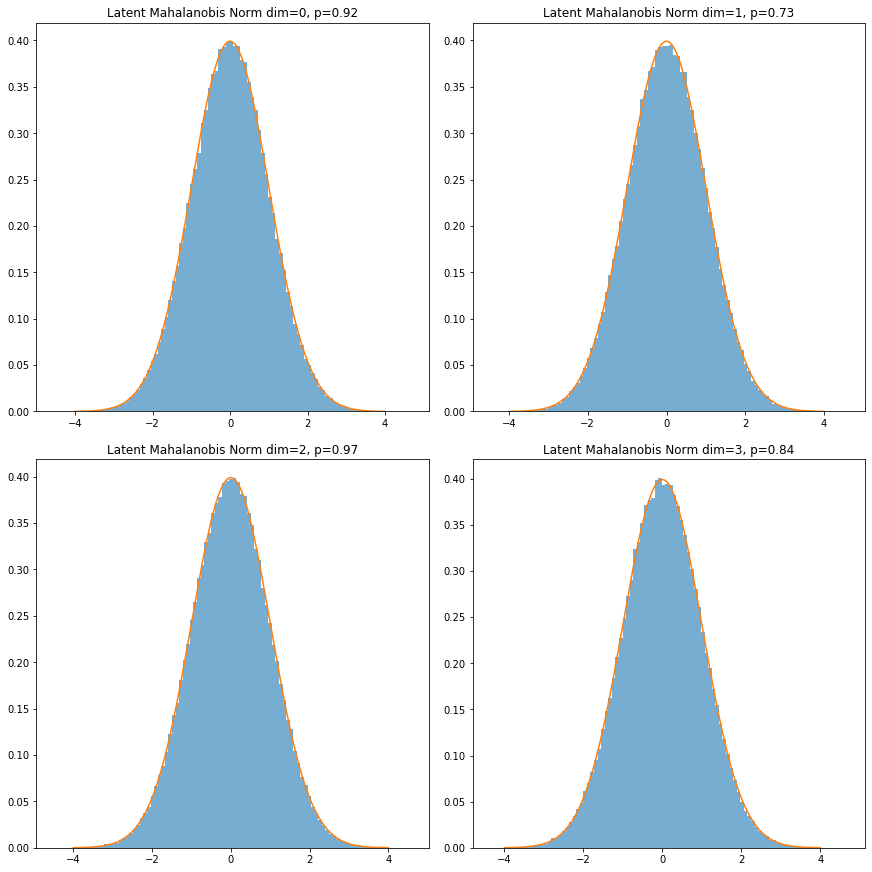

Number of dims: 4


In [7]:
def single_marginal_latent_mahalanobis():
    dim_counter = 0
    
    with torch.no_grad():
        fig, axes = plt.subplots(2,2, figsize=(12, 12), constrained_layout=True)
        axes = axes.flatten()
        for i in tqdm(range(4)):
            ax = axes[i]
            op = out_pos[:, i].to(device)
            m = mean[i]
#             cv = cov[i, i]
            


            ax.hist(((op - m)/op.std()).cpu(), bins=100, density=True,
                     alpha=0.6)

#             print(stats.kstest(((op - m)/op.std()).cpu().flatten(), 'norm'))
            _, p = stats.kstest(((op - m)/op.std()).cpu().flatten(), 'norm')
            if p > 0:
                dim_counter += 1
#             print(stats.kstest(np.random.randn(20000), 'norm'))
#             print(((op - m)/op.std()).cpu().std())
#             print(stats.uniform(-1.7, 3.4).std())
            x = np.linspace(-4, 4, 1000)
#             print(stats.norm.pdf(x).shape)
#             print(stats.uniform.pdf(x, -1, 2).shape)
            e = 0.3
            conv = signal.convolve(stats.uniform.pdf(x, -1.7, 3.4), e*stats.norm.pdf(x/e), 'same')
            conv /= np.sum(e*stats.norm.pdf(x/e))
#             conv *= 8
            ax.plot(x, stats.norm.pdf(x), label='Normal Distribution')
#             ax.plot(x, conv)
#             ax.plot(x, stats.laplace.pdf(x, scale=0.5), label='Laplace Distribution')
            ax.set_title(f'Latent Mahalanobis Norm dim={i}, p={p:.2f}')
        plt.show()
            
    print(f'Number of dims: {dim_counter}')

cov = cov.detach()
mean = mean.detach()
single_marginal_latent_mahalanobis()

100%|██████████| 4/4 [00:00<00:00,  8.75it/s]


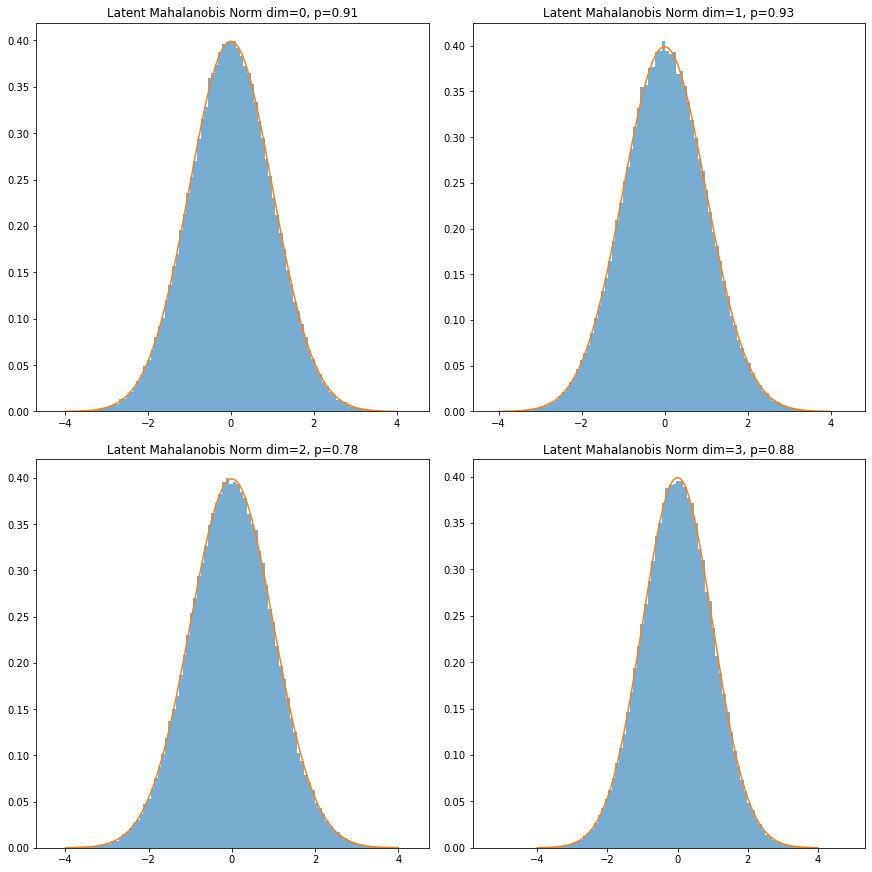

Number of dims: 4


In [8]:
def single_marginal_latent_mahalanobis():
    dim_counter = 0
    
    with torch.no_grad():
        fig, axes = plt.subplots(2,2, figsize=(12, 12), constrained_layout=True)
        axes = axes.flatten()
        for i in tqdm(range(4)):
            ax = axes[i]
            op = in_pos[:, i].to(device)
            m = op.mean()
#             cv = cov[i, i]
            


            ax.hist(((op - m)/op.std()).cpu(), bins=100, density=True,
                     alpha=0.6)

#             print(stats.kstest(((op - m)/op.std()).cpu().flatten(), 'norm'))
            _, p = stats.kstest(((op - m)/op.std()).cpu().flatten(), 'norm')
            if p > 0:
                dim_counter += 1
#             print(stats.kstest(np.random.randn(20000), 'norm'))
#             print(((op - m)/op.std()).cpu().std())
#             print(stats.uniform(-1.7, 3.4).std())
            x = np.linspace(-4, 4, 1000)
#             print(stats.norm.pdf(x).shape)
#             print(stats.uniform.pdf(x, -1, 2).shape)
            e = 0.3
            conv = signal.convolve(stats.uniform.pdf(x, -1.7, 3.4), e*stats.norm.pdf(x/e), 'same')
            conv /= np.sum(e*stats.norm.pdf(x/e))
#             conv *= 8
            ax.plot(x, stats.norm.pdf(x), label='Normal Distribution')
#             ax.plot(x, conv)
#             ax.plot(x, stats.laplace.pdf(x, scale=0.5), label='Laplace Distribution')
            ax.set_title(f'Latent Mahalanobis Norm dim={i}, p={p:.2f}')
        plt.show()
            
    print(f'Number of dims: {dim_counter}')

cov = cov.detach()
mean = mean.detach()
single_marginal_latent_mahalanobis()

100%|██████████| 4/4 [00:00<00:00, 16.80it/s]


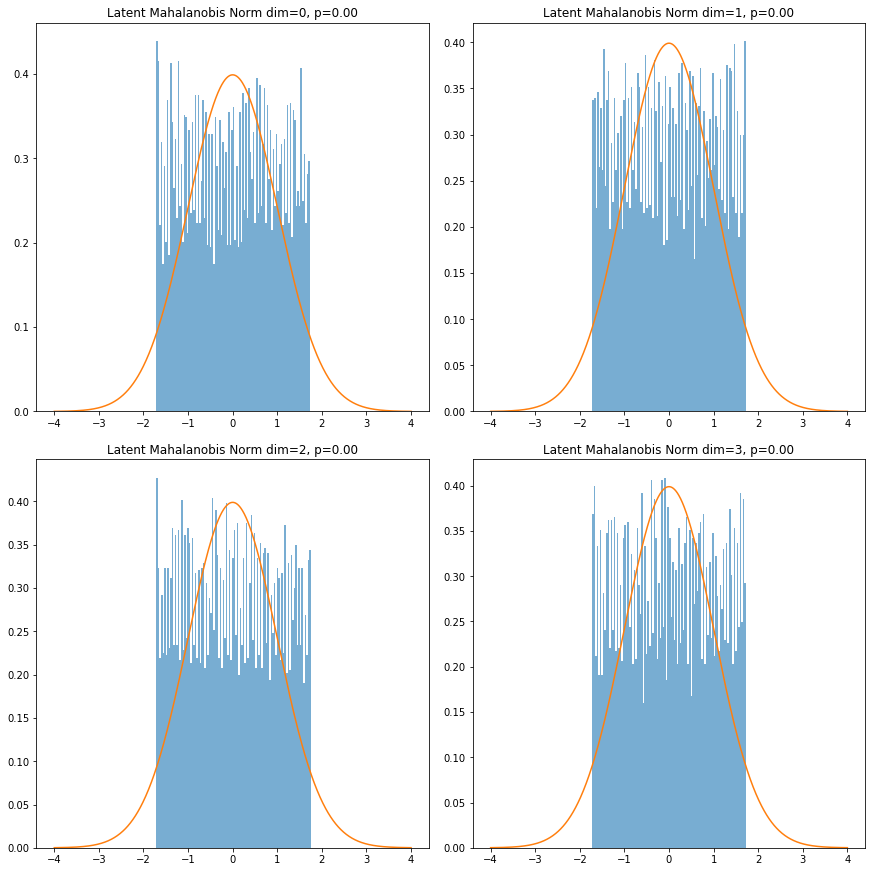

Number of dims: 4


In [9]:
def single_marginal_latent_mahalanobis():
    dim_counter = 0
    
    with torch.no_grad():
        fig, axes = plt.subplots(2,2, figsize=(12, 12), constrained_layout=True)
        axes = axes.flatten()
        test = torch.randn(10000, 1, 2, 2)
        test2 = torch.empty(0, 4)
        for i in range(10000):
            test2 = torch.cat([test2, transforms.functional.to_tensor(transforms.functional.to_pil_image(test[i])).reshape(-1, 4)], dim=0)
        for i in tqdm(range(4)):
            ax = axes[i]
            op = test2[:, i].to(device)
            m = op.mean()
#             cv = cov[i, i]
            


            ax.hist(((op - m)/op.std()).cpu(), bins=100, density=True,
                     alpha=0.6)

#             print(stats.kstest(((op - m)/op.std()).cpu().flatten(), 'norm'))
            _, p = stats.kstest(((op - m)/op.std()).cpu().flatten(), 'norm')
            if p > 0:
                dim_counter += 1
#             print(stats.kstest(np.random.randn(20000), 'norm'))
#             print(((op - m)/op.std()).cpu().std())
#             print(stats.uniform(-1.7, 3.4).std())
            x = np.linspace(-4, 4, 1000)
#             print(stats.norm.pdf(x).shape)
#             print(stats.uniform.pdf(x, -1, 2).shape)
            e = 0.3
            conv = signal.convolve(stats.uniform.pdf(x, -1.7, 3.4), e*stats.norm.pdf(x/e), 'same')
            conv /= np.sum(e*stats.norm.pdf(x/e))
#             conv *= 8
            ax.plot(x, stats.norm.pdf(x), label='Normal Distribution')
#             ax.plot(x, conv)
#             ax.plot(x, stats.laplace.pdf(x, scale=0.5), label='Laplace Distribution')
            ax.set_title(f'Latent Mahalanobis Norm dim={i}, p={p:.2f}')
        plt.show()
            
    print(f'Number of dims: {dim_counter}')

cov = cov.detach()
mean = mean.detach()
single_marginal_latent_mahalanobis()

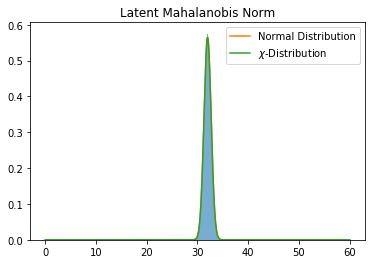

tensor([32.1540, 31.3313, 32.5162,  ..., 31.7762, 31.4606, 32.6844])

In [10]:
def training_set_latent_mahalanobis():
    with torch.no_grad():
        op = out_pos.to(device)
        dc = torch.sqrt((op - mean)[:, None, :] @ icov @
                             (op - mean)[:, :, None]).reshape(-1).cpu()
        plt.hist(dc, bins=100, density=True,
                 alpha=0.6)

        x = np.linspace(0, 60, 1000)
        plt.plot(x, stats.norm.pdf(x, dc.mean(), dc.std()), label='Normal Distribution')
        plt.plot(x, stats.chi.pdf(x, 1024), label='$\chi$-Distribution')
        plt.title(f'Latent Mahalanobis Norm')
        plt.legend()
        plt.show()
        return dc
    
training_set_latent_mahalanobis()